Instructor: Juber Rahman<br>
Dataset: St Petersburg INCART dataset from Physionet<br>
Signal: 12-lead ECG<br>
Pre-processing: neurokit<br>
Method: 1-D CNN or Multi-head CNN<br>
last updated: Nov 12, 2021<br>

**Prework-**<br/>
1.1: Watch a 12 lead ECG video https://www.youtube.com/watch?v=kwLbSx9BNbU <br/> 1.2: read the dataset description from Physionet and identify the heart diseases in the database <br/> 1.3: Which ECG channel data is the most informative for these diseases ? <br/> 1.4 How these diseases MI, CAD, TIA etc. differ from each other, what morphological changes are introduced in the ECG signal? <br/> 1.5 For classification purpose combine the categories with few records into one as 'other' category

In [1]:
!pip install wfdb 

In [2]:
!pip install peakutils

In [3]:
import wfdb
from wfdb import processing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import peakutils

In [4]:
# Download all the WFDB records and annotations from a small Physionet Database

# Make a temporary download directory in your current working directory
cwd = os.getcwd()
dl_dir = os.path.join(cwd, 'tmp_dl_dir')

# Download all the WFDB content
wfdb.dl_database('incartdb', dl_dir=dl_dir)

# Display the downloaded content in the folder
display(os.listdir(dl_dir))

# Cleanup: delete the downloaded directory
#shutil.rmtree(dl_dir)

Generating record list for: I01
Generating record list for: I02
Generating record list for: I03
Generating record list for: I04
Generating record list for: I05
Generating record list for: I06
Generating record list for: I07
Generating record list for: I08
Generating record list for: I09
Generating record list for: I10
Generating record list for: I11
Generating record list for: I12
Generating record list for: I13
Generating record list for: I14
Generating record list for: I15
Generating record list for: I16
Generating record list for: I17
Generating record list for: I18
Generating record list for: I19
Generating record list for: I20
Generating record list for: I21
Generating record list for: I22
Generating record list for: I23
Generating record list for: I24
Generating record list for: I25
Generating record list for: I26
Generating record list for: I27
Generating record list for: I28
Generating record list for: I29
Generating record list for: I30
Generating record list for: I31
Generati

['I54.dat',
 'I23.dat',
 'I64.hea',
 'I29.atr',
 'I63.dat',
 'I51.atr',
 'I58.atr',
 'I53.hea',
 'I23.atr',
 'I45.hea',
 'I62.atr',
 'I49.atr',
 'I27.dat',
 'I11.hea',
 'I67.dat',
 'I24.atr',
 'I16.hea',
 'I25.hea',
 'I14.dat',
 'I16.dat',
 'I16.atr',
 'I40.hea',
 'I28.dat',
 'I01.atr',
 'I08.atr',
 'I52.dat',
 'I59.atr',
 'I68.atr',
 'I63.hea',
 'I43.dat',
 'I64.dat',
 'I38.hea',
 'I56.dat',
 'I62.hea',
 'I53.dat',
 'I17.atr',
 'I75.dat',
 'I19.dat',
 'I21.dat',
 'I03.hea',
 'I46.atr',
 'I74.dat',
 'I60.atr',
 'I34.atr',
 'I18.atr',
 'I05.atr',
 'I48.atr',
 'I34.hea',
 'I46.dat',
 'I10.dat',
 'I50.atr',
 'I24.hea',
 'I60.hea',
 'I18.hea',
 'I66.atr',
 'I37.atr',
 'I09.hea',
 'I10.atr',
 'I56.atr',
 'I13.hea',
 'I70.dat',
 'I22.dat',
 'I57.atr',
 'I02.hea',
 'I11.dat',
 'I31.atr',
 'I72.dat',
 'I73.atr',
 'I08.hea',
 'I64.atr',
 'I15.atr',
 'I68.hea',
 'I11.atr',
 'I45.atr',
 'I27.hea',
 'I17.dat',
 'I03.atr',
 'I49.hea',
 'I24.dat',
 'I69.dat',
 'I50.dat',
 'I72.hea',
 'I53.atr',
 'I0

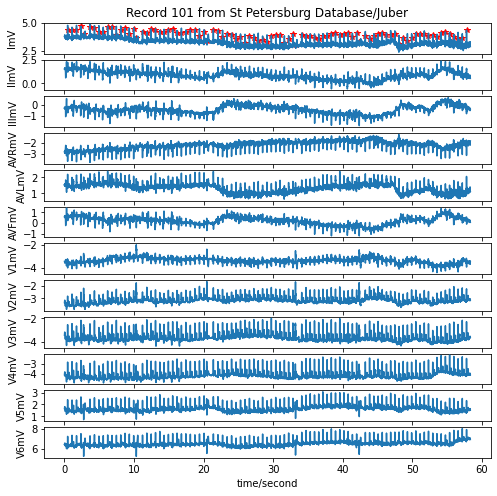

In [5]:
# Read a WFDB record and annotation. Plot all channels, and the annotation on top of channel 0.
record = wfdb.rdrecord('/content/tmp_dl_dir/I01', sampto = 15000)
annotation = wfdb.rdann('/content/tmp_dl_dir/I01', 'atr', sampto = 15000)

from pylab import rcParams
rcParams['figure.figsize'] = 8, 8

wfdb.plot_wfdb(record=record, annotation=annotation,
               title='Record 101 from St Petersburg Database/Juber',
               time_units='seconds')

In [6]:
type(record)

wfdb.io.record.Record

In [7]:
# Read certain channels and sections of the WFDB record using the simplified 'rdsamp' function
# which returns a numpy array and a dictionary. Show the data.
signals_ch0, fields = wfdb.rdsamp('/content/tmp_dl_dir/I01', channels=[0], sampfrom=257, sampto=15000)
display(signals_ch0)
display(fields)

array([[3.62091503],
       [3.66339869],
       [3.62091503],
       ...,
       [2.91830065],
       [2.90196078],
       [2.89215686]])

{'base_date': None,
 'base_time': None,
 'comments': ['<age>: 65 <sex>: F <diagnoses> Coronary artery disease, arterial hypertension',
  'patient 1',
  'PVCs, noise'],
 'fs': 257,
 'n_sig': 1,
 'sig_len': 14743,
 'sig_name': ['I'],
 'units': ['mV']}

In [8]:
# Use the GQRS detection algorithm and correct the peaks

def peaks_hr(sig, peak_inds, fs, title, figsize=(10, 5), saveto=None):
    "Plot a signal with its peaks and heart rate"
    # Calculate heart rate
    hrs = processing.hr.compute_hr(sig_len=sig.shape[0], qrs_inds=peak_inds, fs=fs)
    
    N = sig.shape[0]
    
    fig, ax_left = plt.subplots(figsize=figsize)
    ax_right = ax_left.twinx()
    
    ax_left.plot(sig, color='#3979f0', label='Signal')
    ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x', 
                 color='#8b0000', label='Peak', markersize=12)
    ax_right.plot(np.arange(N), hrs, label='Heart rate', color='m', linewidth=2)

    ax_left.set_title(title)

    ax_left.set_xlabel('Time (ms)')
    ax_left.set_ylabel('ECG (mV)', color='#3979f0')
    ax_right.set_ylabel('Heart rate (bpm)', color='m')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax_left.tick_params('y', colors='#3979f0')
    ax_right.tick_params('y', colors='m')
    if saveto is not None:
        plt.savefig(saveto, dpi=600)
    plt.show()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "rx" (-> marker='x'). The keyword argument will take precedence.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rx" (-> color='r'). The keyword argument will take precedence.
  from ipykernel import kernelapp as app


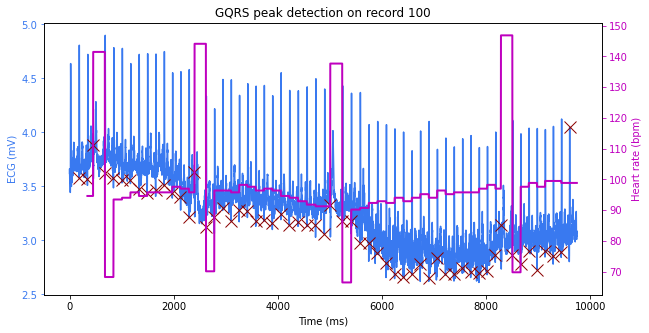

Corrected GQRS detected peak indices: [187, 351, 506, 685, 850, 1014, 1176, 1338, 1500, 1660, 1821, 1980, 2139, 2299, 2450, 2627, 2786, 2946, 3107, 3265, 3423, 3583, 3741, 3901, 4064, 4228, 4394, 4563, 4731, 4900, 5058, 5245, 5415, 5585, 5752, 5918, 6086, 6249, 6415, 6578, 6742, 6905, 7065, 7228, 7389, 7550, 7710, 7870, 8026, 8185, 8332, 8511, 8669, 8825, 8983, 9138, 9293, 9450, 9604]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "rx" (-> marker='x'). The keyword argument will take precedence.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rx" (-> color='r'). The keyword argument will take precedence.
  from ipykernel import kernelapp as app


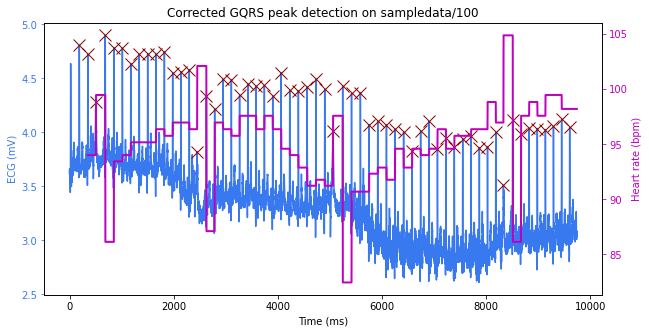

In [9]:

# Load the WFDB record and the physical samples
record = wfdb.rdrecord('/content/tmp_dl_dir/I01', sampfrom=257, sampto=10000, channels=[0])

# Use the GQRS algorithm to detect QRS locations in the first channel
qrs_inds = processing.qrs.gqrs_detect(sig=record.p_signal[:,0], fs=record.fs)

# Plot results
peaks_hr(sig=record.p_signal, peak_inds=qrs_inds, fs=record.fs,
         title="GQRS peak detection on record 100")
    
# Correct the peaks shifting them to local maxima
min_bpm = 20
max_bpm = 230
#min_gap = record.fs * 60 / min_bpm
# Use the maximum possible bpm as the search radius
search_radius = int(record.fs * 60 / max_bpm)
corrected_peak_inds = processing.peaks.correct_peaks(record.p_signal[:,0], 
                                                     peak_inds=qrs_inds,
                                                     search_radius=search_radius, 
                                                     smooth_window_size=150)

# Display results
print('Corrected GQRS detected peak indices:', sorted(corrected_peak_inds))
peaks_hr(sig=record.p_signal, peak_inds=sorted(corrected_peak_inds), fs=record.fs,
         title="Corrected GQRS peak detection on sampledata/100")

In [10]:
# Load the WFDB record and the physical samples
signals, fields = wfdb.rdsamp('/content/tmp_dl_dir/I01', channels=[0,1,2,3,4,5,6,7,8,9,10,11])

In [11]:
signals.shape

(462600, 12)

In [12]:
print(signals.T.shape)

(12, 462600)


In [14]:
%load'/content/Enhancementing-Method-for-STEMI-Detection-master/Process/preprocessing.py' 

ValueError: ignored

In [13]:
signals_T=signals.T
print(signals_T.shape)
np.savetxt("/content/Enhancementing-Method-for-STEMI-Detection-master/data.csv", signals_T, delimiter=",")

(12, 462600)


FileNotFoundError: ignored

In [ ]:
import neurokit2 as nk

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 8,8

# Process it
signals, info = nk.ecg_process(signals_ch0.flatten() , sampling_rate=250)

# Visualise the processing
nk.ecg_plot(signals, sampling_rate=250)

### **TO DO** - rest of the project including feature extraction, classification, feature ranking, etc.